In [11]:
import os
import glob
import itertools

import torch

import numpy as np

import matplotlib.pyplot as plt

from GPy.core.parameterization.priors import Gamma, InverseGamma

import astropy.time as atime
from astropy.coordinates import SkyCoord
from astropy.io import fits

from ps_eor import datacube, pspec, psutil, simu, fitutil, fgfit, flagger, ml_gpr, obssimu
from ps_eor.ml_gpr import VAEFitter, BetaVAE, PCAFitter

from pspipe import database, settings

from nenucal import msutils, delayflag
from libpipe import worker

import matplotlib as mpl
mpl.use('Agg')

from astropy.cosmology import FlatLambdaCDM
psutil.set_cosmology(FlatLambdaCDM(100, Om0=0.30964))

mpl.rcParams['image.cmap'] = 'Spectral_r'
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['axes.grid'] = True

%matplotlib inline

# Avoidance

reconstraining parameters fg_int.variance
reconstraining parameters fg_mix_theta.variance
reconstraining parameters eor_vae.variance
 <ipython-input-8-c1c45d60477e>:56: RuntimeWarning:invalid value encountered in sqrt
reconstraining parameters fg_int.variance
reconstraining parameters fg_mix_theta.variance
reconstraining parameters eor_vae.variance
 <ipython-input-8-c1c45d60477e>:56: RuntimeWarning:invalid value encountered in sqrt
reconstraining parameters fg_int.variance
reconstraining parameters fg_mix_theta.variance
reconstraining parameters eor_vae.variance
 <ipython-input-8-c1c45d60477e>:56: RuntimeWarning:invalid value encountered in sqrt
reconstraining parameters fg_int.variance
reconstraining parameters fg_mix_theta.variance
reconstraining parameters eor_vae.variance
 <ipython-input-8-c1c45d60477e>:56: RuntimeWarning:invalid value encountered in sqrt
reconstraining parameters fg_int.variance
reconstraining parameters fg_mix_theta.variance
reconstraining parameters eor_vae.vari

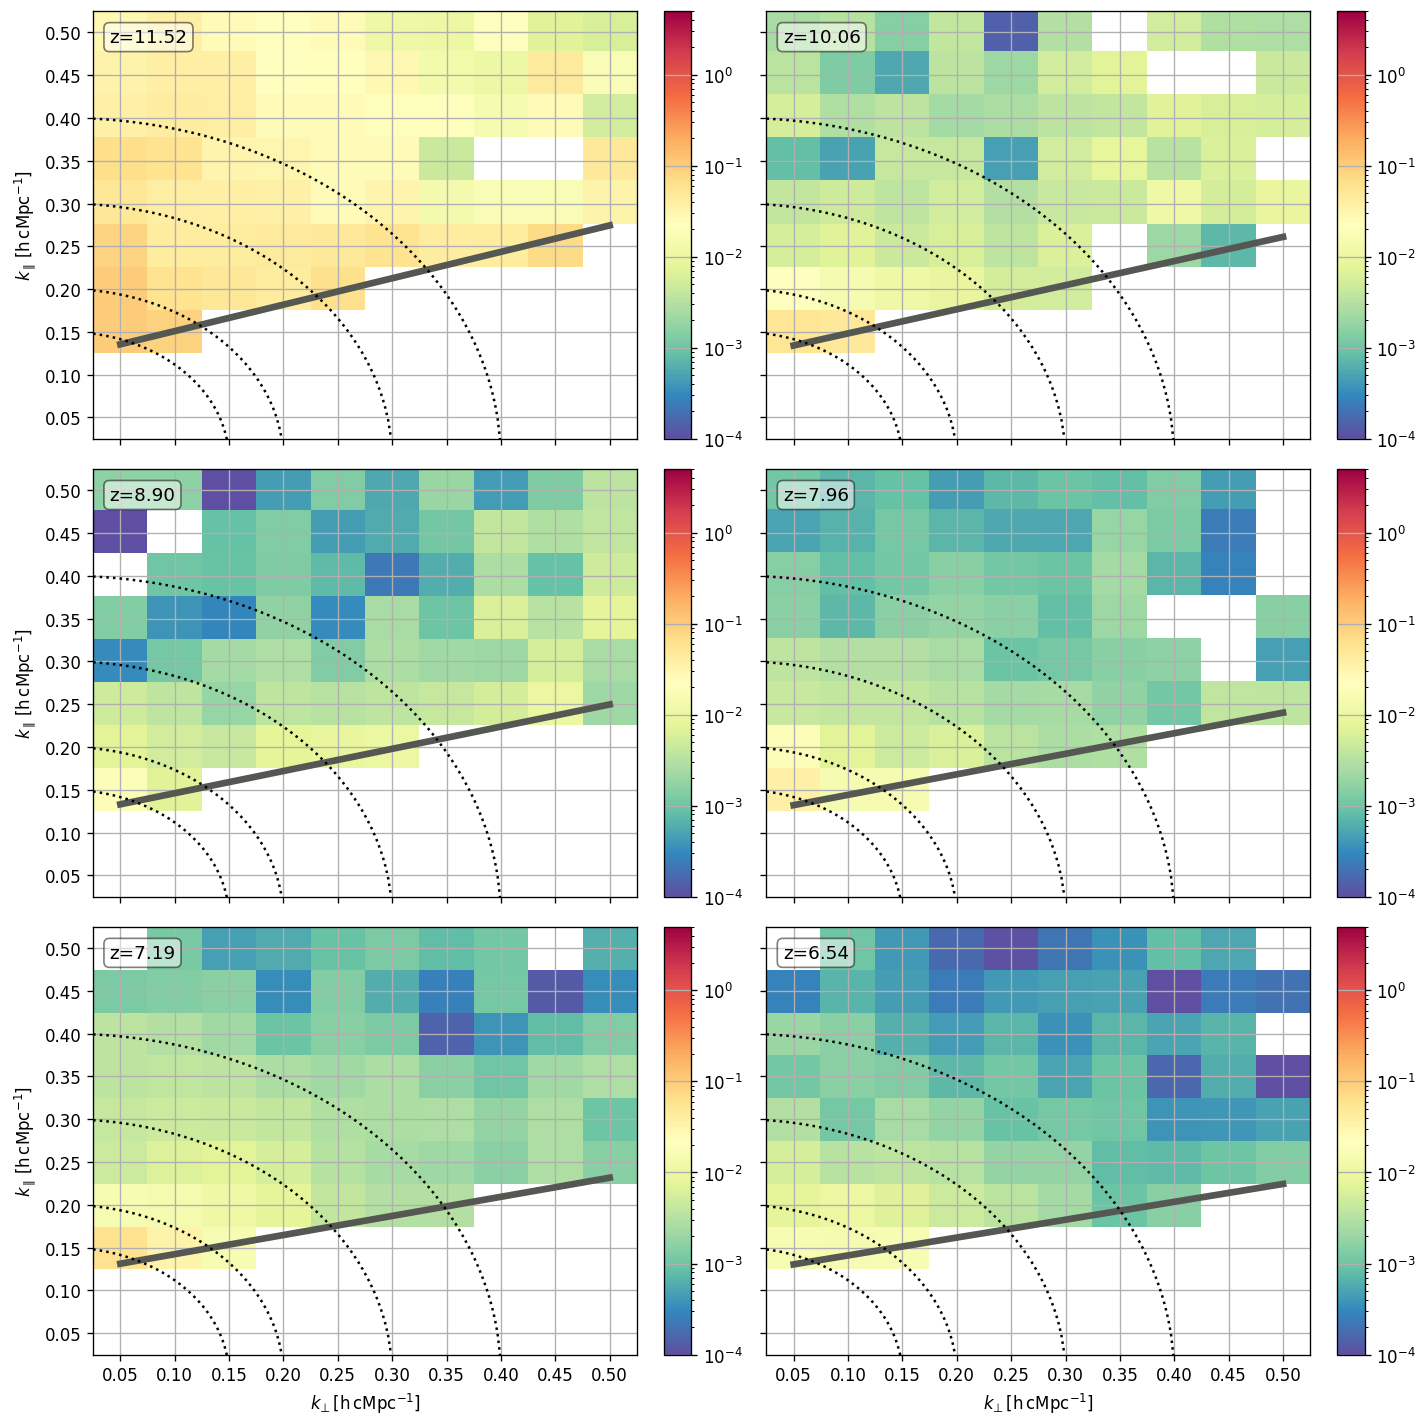

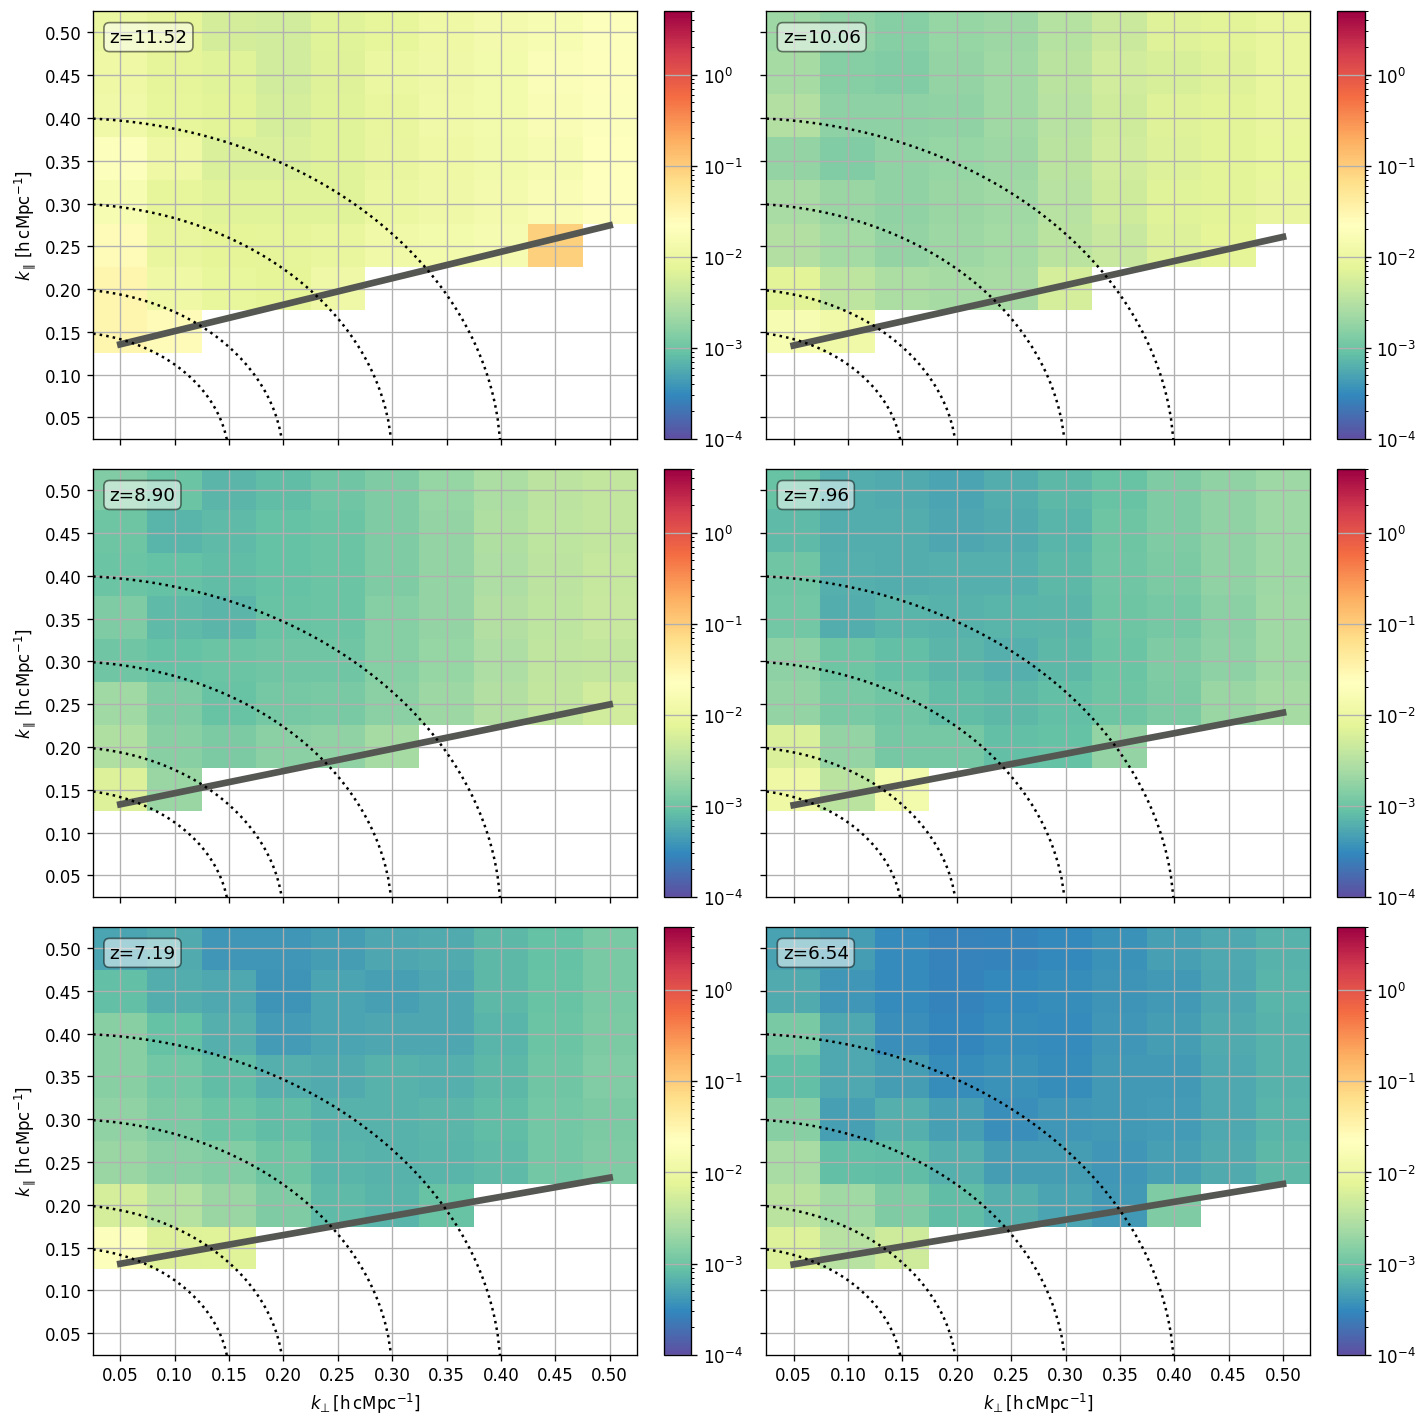

In [8]:
fig, axs = plt.subplots(figsize=(12, 12), dpi=120, sharey=True, sharex=True, ncols=2, nrows=3)
fig2, axs2 = plt.subplots(figsize=(12, 12), dpi=120, sharey=True, sharex=True, ncols=2, nrows=3)

rev_name = 'run05'
gpr_name_2 = 'ml_gpr_t4'
data_name = 'data_sub_combined_diffuse_t7'

for i, (fmin, ax, ax2) in enumerate(zip([106, 121, 136, 151, 166, 181], axs.flatten(), axs2.flatten())):
    rev = database.VisRevision(settings.Settings.load_with_defaults(f'/net/node100/data/users/lofareor/mertens/sdc3/batch_run/ps/{rev_name}.toml'))

    data = rev.get_data(f'{data_name}_f{fmin}')
    i = int((fmin - 106) / 15)

    ml_res = data.get_ml_gpr_res(i, 30, 550, name=gpr_name_2)
    noise_cube = ml_res.get_noise_cube()
    noise_cube.weights = ml_res.get_data_cube().weights.copy()
    
    i_cube = ml_res.get_data_cube()
    fitter = fgfit.PolyForegroundFit(4, 'power_poly')
    i_cube = fitter.run(i_cube, noise_cube).sub

    z = psutil.freq_to_z(i_cube.freqs.mean())
    du = psutil.k_to_l(0.05, z) / (2 * np.pi)
    umin = du / 2.
    umax = psutil.k_to_l(0.5, z) / (2 * np.pi) + du / 2
    M = int((1 / psutil.k_to_delay(0.05, z)) / 0.1e6)
    ps_gen_bh = data.get_ps_gen(ft_method='nudft', window_fct='hann', primary_beam='ska_low', rmean_freqs=False, du=du, umin=umin, umax=umax, uniform_u_bins=True,
                                filter_wedge_theta=4, filter_kpar_min=0.12)
    ps_gen_bh.eor.M = M
    ps_gen_bh._compute_delays()
    ps2d_avoid = (ps_gen_bh.get_ps2d(i_cube) - ps_gen_bh.get_ps2d(noise_cube))
    ps2d_avoid.plot(ax=ax, vmin=1e-4, vmax=5e0)
    
    ps2d_avoid.new_with_data(ps2d_avoid.err, ps2d_avoid.err).plot(ax=ax2, vmin=1e-4, vmax=5e0)
    
    res_dir = f'/home/users/mertens/projects/challenges/sdc3/ml_gpr_results/{rev_name}/{gpr_name_2}/'
    filename = f'DOTSS-21-avoidance_{fmin}MHz-{fmin + 15}MHz'
    
#     np.savetxt(f'{res_dir}/{filename}.data', ps2d_avoid.data[:10], fmt='%.10f')
#     np.savetxt(f'{res_dir}/{filename}_errors.data', ps2d_avoid.err[:10], fmt='%.10f')

    props = dict(boxstyle='round', facecolor='white', alpha=0.5)

    for ax in [ax, ax2]:
        k_par_fg_line = psutil.wedge_fct(np.radians(4), ps_gen_bh.eor.z, ps2d_avoid.k_per) + 0.12
        ax.plot(ps2d_avoid.k_per, k_par_fg_line, lw=4, c=psutil.black)
        ax.text(0.03, 0.96, f'z={ps_gen_bh.eor.z:.2f}', transform=ax.transAxes, fontsize=11, va='top', bbox=props)

        ax.get_images()[0].set_extent([0.025, 0.525, 0.025, ps_gen_bh.k_par.max() + 0.025])
        ax.set_ylim(ymin=0.025, ymax=0.525)
        ax.set_xlim(xmin=0.025, xmax=0.525)
        ax.set_xticks(np.arange(0.05, 0.55, 0.05))
        ax.set_yticks(np.arange(0.05, 0.55, 0.05))
        for k in [0.15, 0.2, 0.3, 0.4]:
            k_per = np.linspace(0.025, 0.525, num=200)
            k_par = (k ** 2 - (k_per) ** 2) ** .5
            ax.plot(k_per, k_par, ls=':', c='black')
        
for axs in [axs, axs2]:
    for ax in axs[:-1].flatten():
        ax.set_xlabel('')
    for ax in axs[:, 1:].flatten():
        ax.set_ylabel('')

fig.tight_layout()
fig2.tight_layout()

# ML-GPR

 <ipython-input-10-78e15e366a5b>:59: RuntimeWarning:invalid value encountered in sqrt
 <ipython-input-10-78e15e366a5b>:59: RuntimeWarning:invalid value encountered in sqrt
 <ipython-input-10-78e15e366a5b>:59: RuntimeWarning:invalid value encountered in sqrt
 <ipython-input-10-78e15e366a5b>:59: RuntimeWarning:invalid value encountered in sqrt
 <ipython-input-10-78e15e366a5b>:59: RuntimeWarning:invalid value encountered in sqrt
 <ipython-input-10-78e15e366a5b>:59: RuntimeWarning:invalid value encountered in sqrt


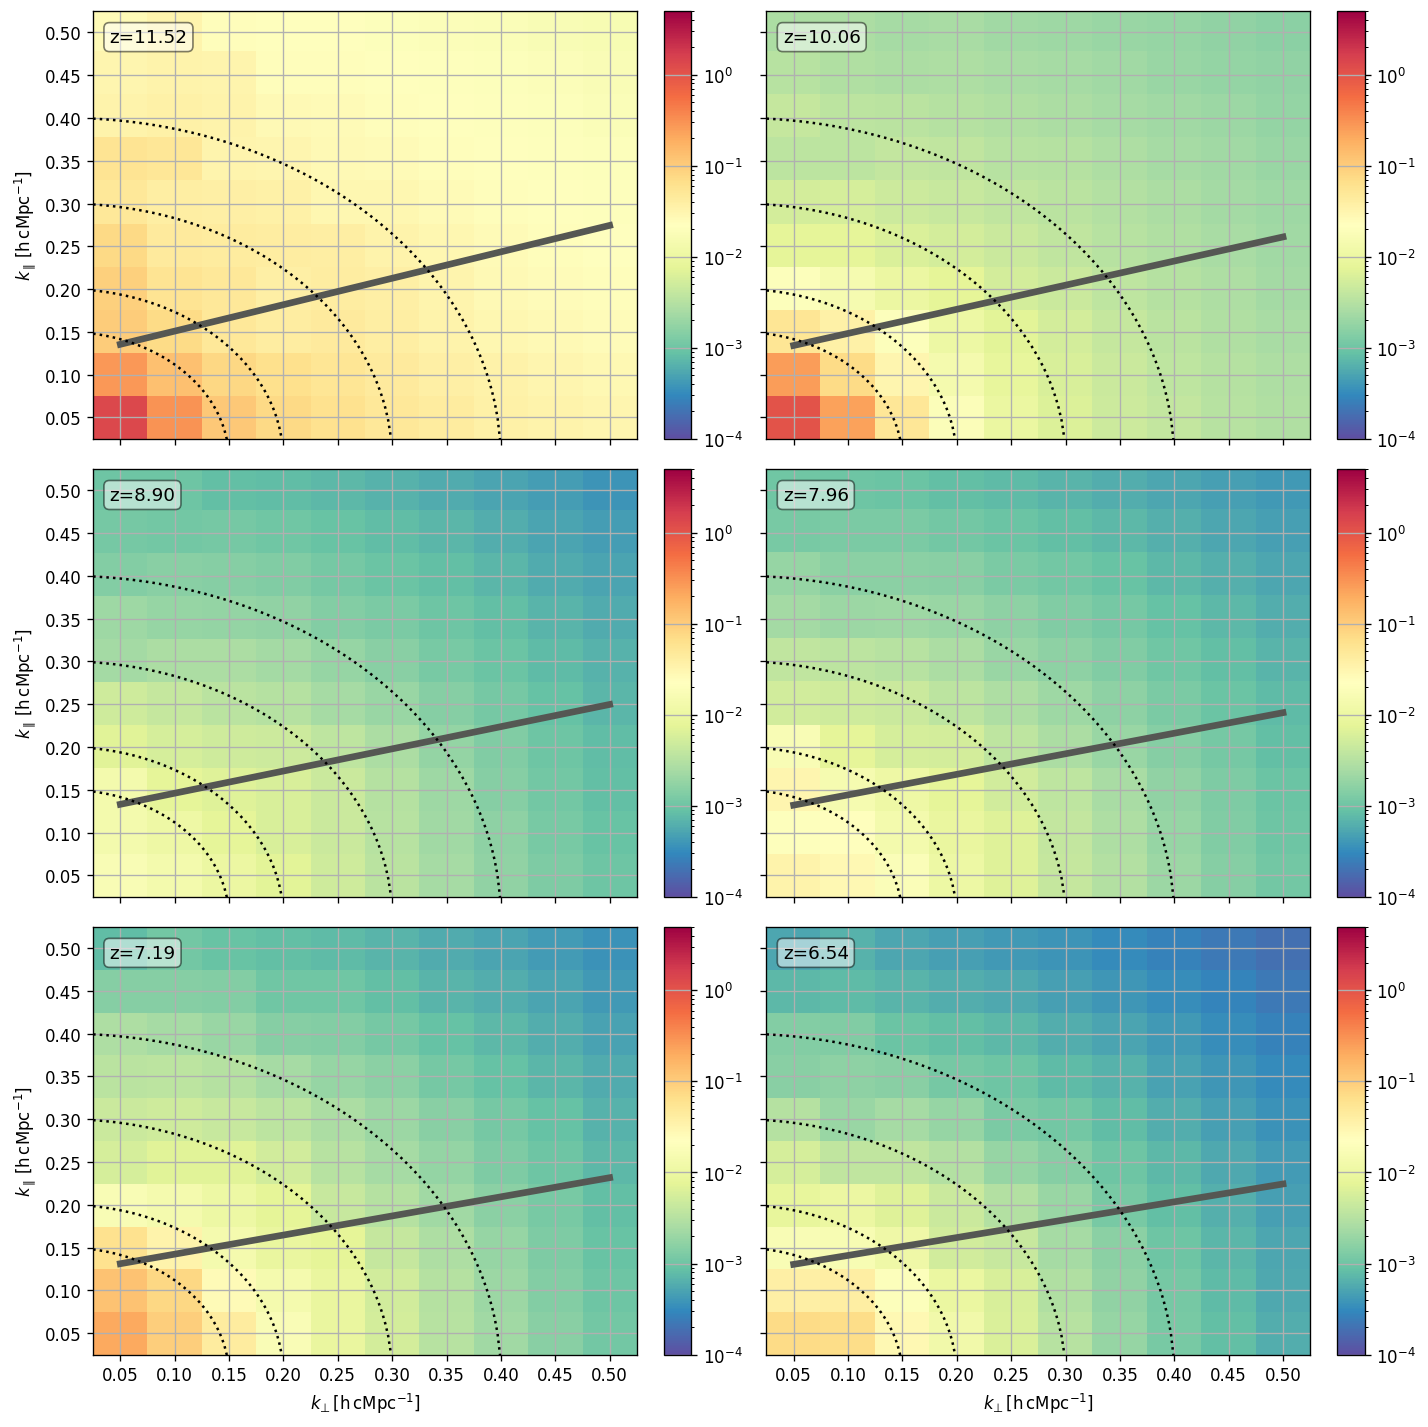

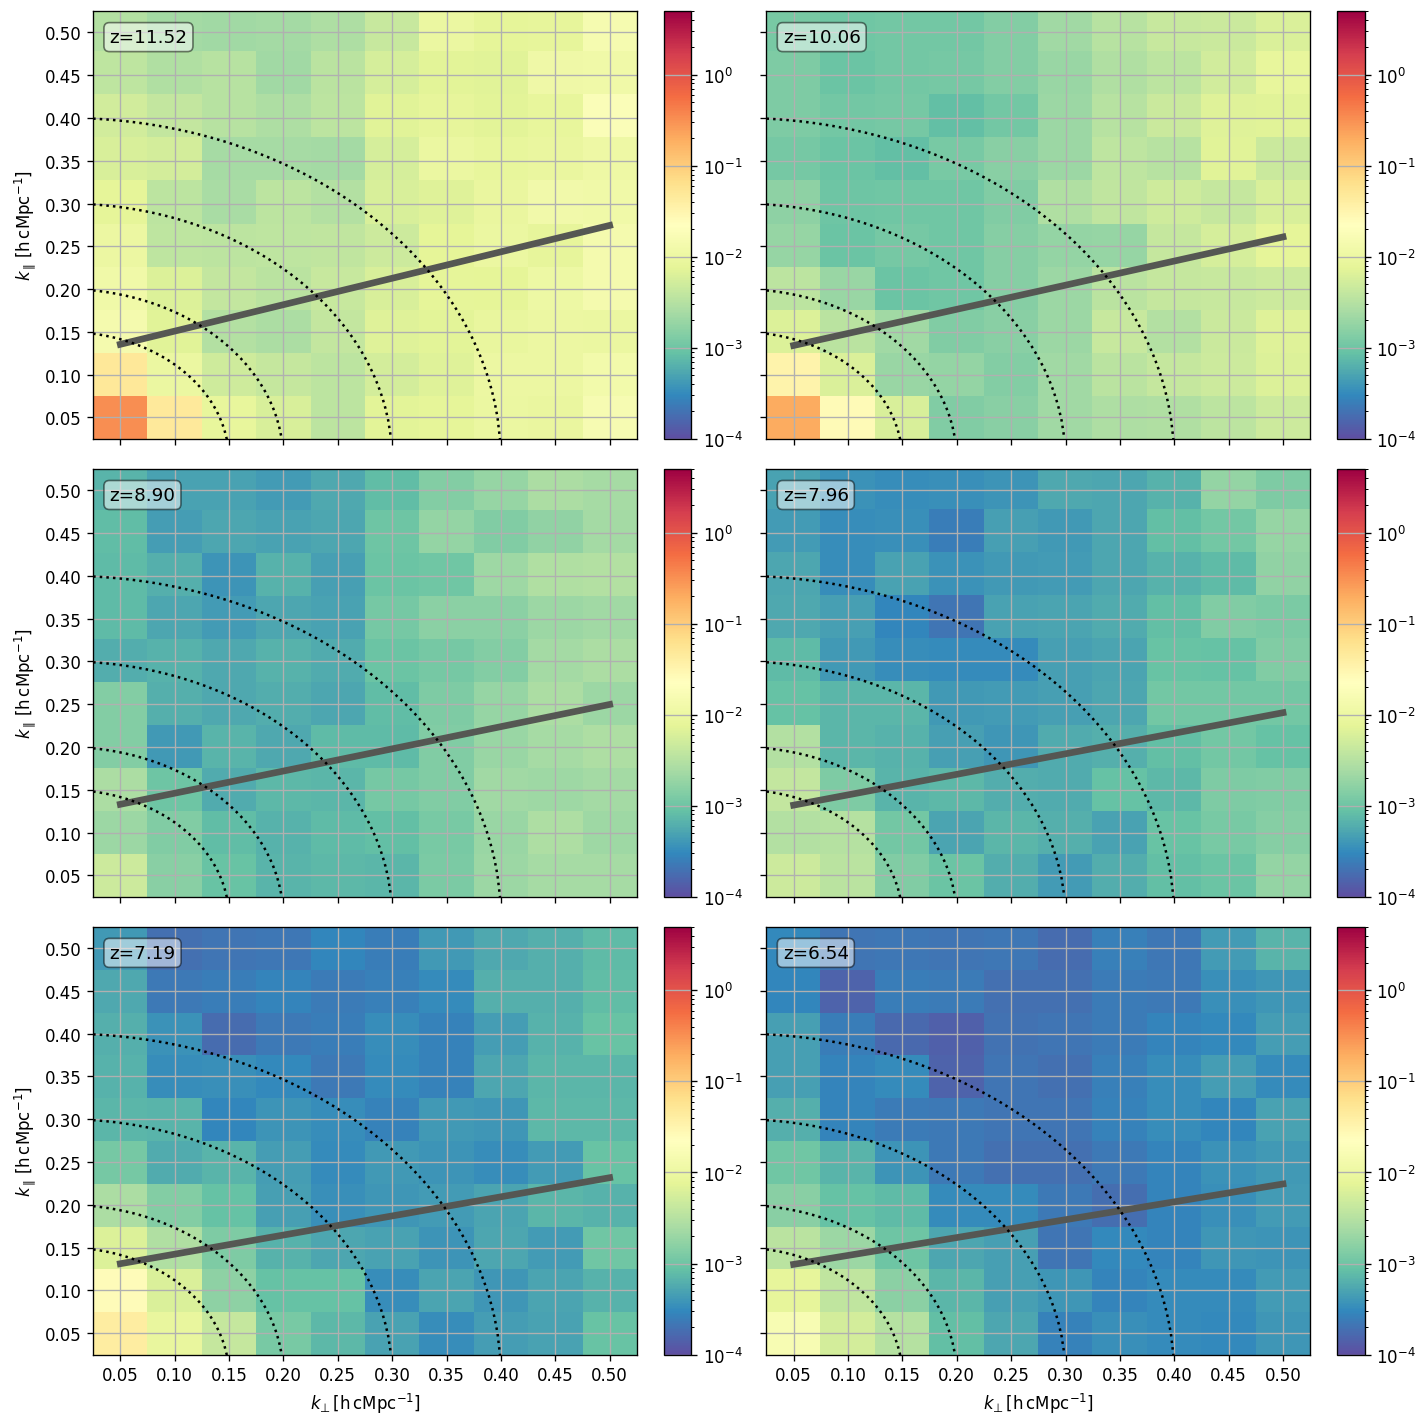

In [10]:
fig, axs = plt.subplots(figsize=(12, 12), dpi=120, sharey=True, sharex=True, ncols=2, nrows=3)
fig2, axs2 = plt.subplots(figsize=(12, 12), dpi=120, sharey=True, sharex=True, ncols=2, nrows=3)

rev_name = 'run05'
gpr_name_2 = 'ml_gpr_t4'
data_name = 'data_sub_combined_diffuse_t7'
method = 'advanced-ml-gpr'

# data_name = 'data_sub_combined'
# method = 'ml-gpr'

a_ps2d = []

for i, (fmin, ax, ax2) in enumerate(zip([106, 121, 136, 151, 166, 181], axs.flatten(), axs2.flatten())):
    rev = database.VisRevision(settings.Settings.load_with_defaults(f'/net/node100/data/users/lofareor/mertens/sdc3/batch_run/ps/{rev_name}.toml'))

    data = rev.get_data(f'{data_name}_f{fmin}')
    i = int((fmin - 106) / 15)

    z = psutil.freq_to_z(data.i.freqs.mean())
    du = psutil.k_to_l(0.05, z) / (2 * np.pi)
    umin = du / 2.
    umax = psutil.k_to_l(0.5, z) / (2 * np.pi) + du / 2
    M = int((1 / psutil.k_to_delay(0.05, z)) / 0.1e6)

    ps_gen_bh = data.get_ps_gen(ft_method='nudft', window_fct='hann', primary_beam='ska_low', rmean_freqs=False, du=du, umin=umin, umax=umax, uniform_u_bins=True,
                                filter_wedge_theta=4, filter_kpar_min=0.12)

    ps2d_final_res = pspec.CylindricalPowerSpectraMC.load(f'/home/users/mertens/projects/challenges/sdc3/ml_gpr_results/{rev_name}/{gpr_name_2}/{data_name}_f{fmin}/ps2d_final.h5')
    ps2d_final = pspec.CylindricalPowerSpectra.load(f'/home/users/mertens/projects/challenges/sdc3/ml_gpr_results/{rev_name}/{gpr_name_2}/{data_name}_f{fmin}/ps2d_final_eor_cv.h5')
    ps2d_final.plot(ax=ax, vmin=1e-4, vmax=5e0)
    k_par_fg_line = psutil.wedge_fct(np.radians(4), ps_gen_bh.eor.z, ps2d_final.k_per) + 0.12
    
    ps2d_final.new_with_data(ps2d_final.err, ps2d_final.err).plot(ax=ax2, vmin=1e-4, vmax=5e0)
    a_ps2d.append(ps2d_final)
    
#     ps2d_final.new_with_data((ps2d_final_res.data - ps2d_final.data) / ps2d_final.err, ps2d_final.err).plot(ax=ax3, vmin=-5, vmax=5, log_norm=False, cmap='coolwarm')
#     (ps2d_final_res / ps2d_final).plot(ax=ax3, vmin=0.1, vmax=10, log_norm=True, cmap='coolwarm')
    
    res_dir = f'/home/users/mertens/projects/challenges/sdc3/ml_gpr_results/{rev_name}/{gpr_name_2}_eor_cv/'
    os.makedirs(res_dir, exist_ok=True)
    filename = f'DOTSS-21-{method}_{fmin}MHz-{fmin + 15}MHz'
#     np.savetxt(f'{res_dir}/{filename}.data', ps2d_final.data[:10], fmt='%.10f')
#     np.savetxt(f'{res_dir}/{filename}_errors.data', ps2d_final.err[:10], fmt='%.10f')

    props = dict(boxstyle='round', facecolor='white', alpha=0.5)

    for ax in [ax, ax2]:
        ax.plot(ps2d_final.k_per, k_par_fg_line, lw=4, c=psutil.black)
        ax.text(0.03, 0.96, f'z={ps_gen_bh.eor.z:.2f}', transform=ax.transAxes, fontsize=11, va='top', bbox=props)

        ax.get_images()[0].set_extent([0.025, 0.525, 0.025, ps2d_final.k_par.max() + 0.025])
        ax.set_ylim(ymin=0.025, ymax=0.525)
        ax.set_xlim(xmin=0.025, xmax=0.525)
        ax.set_xticks(np.arange(0.05, 0.55, 0.05))
        ax.set_yticks(np.arange(0.05, 0.55, 0.05))
        for k in [0.15, 0.2, 0.3, 0.4]:
            k_per = np.linspace(0.025, 0.525, num=200)
            k_par = (k ** 2 - (k_per) ** 2) ** .5
            ax.plot(k_per, k_par, ls=':', c='black')
        
for axs in [axs, axs2]:
    for ax in axs[:-1].flatten():
        ax.set_xlabel('')
    for ax in axs[:, 1:].flatten():
        ax.set_ylabel('')

# fig.legend(ncol=6, bbox_to_anchor=(0.5, 1.05), loc='upper center')
fig.tight_layout()
fig2.tight_layout()
